# plot loss curves

In [24]:
# TODO: load from file
import os
import numpy as np

dataset_name = 'MolecularFingerprint_REDDIT-BINARY_assessment'

def load_logs(date=None, name=None) -> dict:
    
    def extract_data(data_path) -> list:
        with open(data_path, 'r') as f:
            data = []
            for line in f.readlines():
                if not line.startswith('Epoch'):
                    continue
                
                line = line.strip().replace(',', '')
                l = line.split(' ')
                s_l = [l[4], l[7], l[10], l[13], l[16], l[19]]
                f_l = []
                for i in s_l:
                    try:
                        fi = float(i)
                    except Exception as e:
                        fi = 0.0
                    f_l.append(fi)
                        
                data.append(f_l)
            return np.array(data)
    
    
    if date is not None:
        root_dir = f'results/result_{date}/'
        dirs = os.listdir(f'results/result_{date}/')
        print(dirs)
        dataset_log = {}
        for d in dirs:
            dd = os.path.join(root_dir, d, '10_NESTED_CV')
            outer_dirs = os.listdir(dd)
            log_folds = []
            for i, id_name in enumerate(outer_dirs):
                if not os.path.isdir(os.path.join(dd, id_name)):
                    continue
                """
                Epoch: 1, TR loss: 433.2928585476345 TR acc: 48.641975308641975, VL loss: 479.35484415690104 VL acc: 47.77777854071723 TE loss: 101.24097244262695 TE acc: 39.0
                Epoch: 10, TR loss: 9.24662885548156 TR acc: 65.4320987654321, VL loss: 324.07152099609374 VL acc: 70.00000135633681 TE loss: 13.453640460968018 TE acc: 62.0
                Epoch: 20, TR loss: 11.454432420377378 TR acc: 59.75308641975309, VL loss: 148.55850830078126 VL acc: 54.444445376926 TE loss: 30.56077377319336 TE acc: 53.0
                Epoch: 30, TR l
                """
                file_dir = os.path.join(dd, id_name, 'experiment.log')
                data = extract_data(file_dir)
                log_folds.append(data)
            dataset_log[d] = log_folds
        return dataset_log
    
    elif name is not None:
        # TODO: search the best config:
        root_path = f"results/{name}/"
        dirs = os.listdir(root_path)
        
        folds_data = {} # TODO store data.
        for d in dirs:
            # search 10 folds:
            
            folds = []
            for i in range(1, 11):
                fold_dir = os.path.join(root_path, d, f'10_NESTED_CV/OUTER_FOLD_{i}/HOLDOUT_MS/')
                configs = os.listdir(fold_dir)
                # print winner config. TODO.
                best_vl_acc = 0.0
                best_conf = None
                if len(configs) < 3:
                    # only one config.
                    best_conf = 'config_1'
                else:
                    for cf in configs:
                        if not os.path.isdir(os.path.join(fold_dir,cf)):
                            continue
                        config_res = os.path.join(fold_dir, cf, 'experiment.log')
                        with open(config_res,'r') as f:
                            for l in f.readlines():
                                if 'best' in l:
                                    vlacc = float(l.split(' ')[9].split(',')[0])
                                    if vlacc > best_vl_acc:
                                        best_conf = cf
                                        best_vl_acc = vlacc
                                    
                print('best_conf:', best_conf, 'acc:', best_vl_acc)
                # TODO: load the best again.
                best_conf_path = os.path.join(fold_dir, best_conf, 'experiment.log')
                best_data = extract_data(best_conf_path)
                folds.append(best_data)
            folds_data[d] = folds
            
        return folds_data
                
                
        # with open()
"""
Epoch: 750, TR loss: 1.7823815012174378 TR acc: 13.374485612406161, VL loss: 1.8264499328754566 VL acc: 16.666666949236834 TE loss: None TE acc: None
Stopping at epoch 751, best is (1.9384536331082567, 17.489711965553063, 1.841690769901982, 22.22222222222222, None, None, 251)
TR Accuracy: 17.489711965553063 VL Accuracy: 22.22222222222222
"""
    

'\nEpoch: 750, TR loss: 1.7823815012174378 TR acc: 13.374485612406161, VL loss: 1.8264499328754566 VL acc: 16.666666949236834 TE loss: None TE acc: None\nStopping at epoch 751, best is (1.9384536331082567, 17.489711965553063, 1.841690769901982, 22.22222222222222, None, None, 251)\nTR Accuracy: 17.489711965553063 VL Accuracy: 22.22222222222222\n'

In [25]:
stats = load_logs(name='result_GIN_0128')
# TODO: plot all config_17 or the best config?



configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0
configs: ['config_1', 'winner_config.json']
best_conf: config_1 acc: 0.0


# Plot best:

In [26]:
for k, v in stats.items():
    print('dataset name: ', k, 'fold len:', len(v))

dataset name:  GIN_MUTAG_assessment fold len: 10


In [ ]:
stats = load_logs(date=1020)


for k, v in stats.items():
    print('dataset name: ', k, 'fold len:', len(v))

In [11]:
# TODO: plot

# TODO: def histogram
import matplotlib.pyplot as plt

def plot_loss_curve(data_states:list=None, titles:list=None):

    total = len(data_states)
    
    if total == 1:
        folds = data_states[0]
        name = titles[0]
        
        fig, axes = plt.subplots(4, 3, figsize=(10, 8), dpi=300)
        for idx, fold in enumerate(folds):
            axe = axes[int(idx/3)][idx%3]
            axe.plot(fold[:, 0]) # train loss
            axe.plot(fold[:, 2]) # val loss
            # TODO: acc, right axis
            
            axe.set_title(f'fold: {idx}')
        if len(folds)%3 > 0:
            for d in range(3-total%3):
                fig.delaxes(axes[-1][-d-1])
        fig.suptitle(','.join(name.split('_')[:2]))
        fig.legend(['train loss', 'val_loss'], loc='lower right')
        # fig.title(','.join(name.split('_')[:2]))
    
    plt.tight_layout()
    plt.show()
    

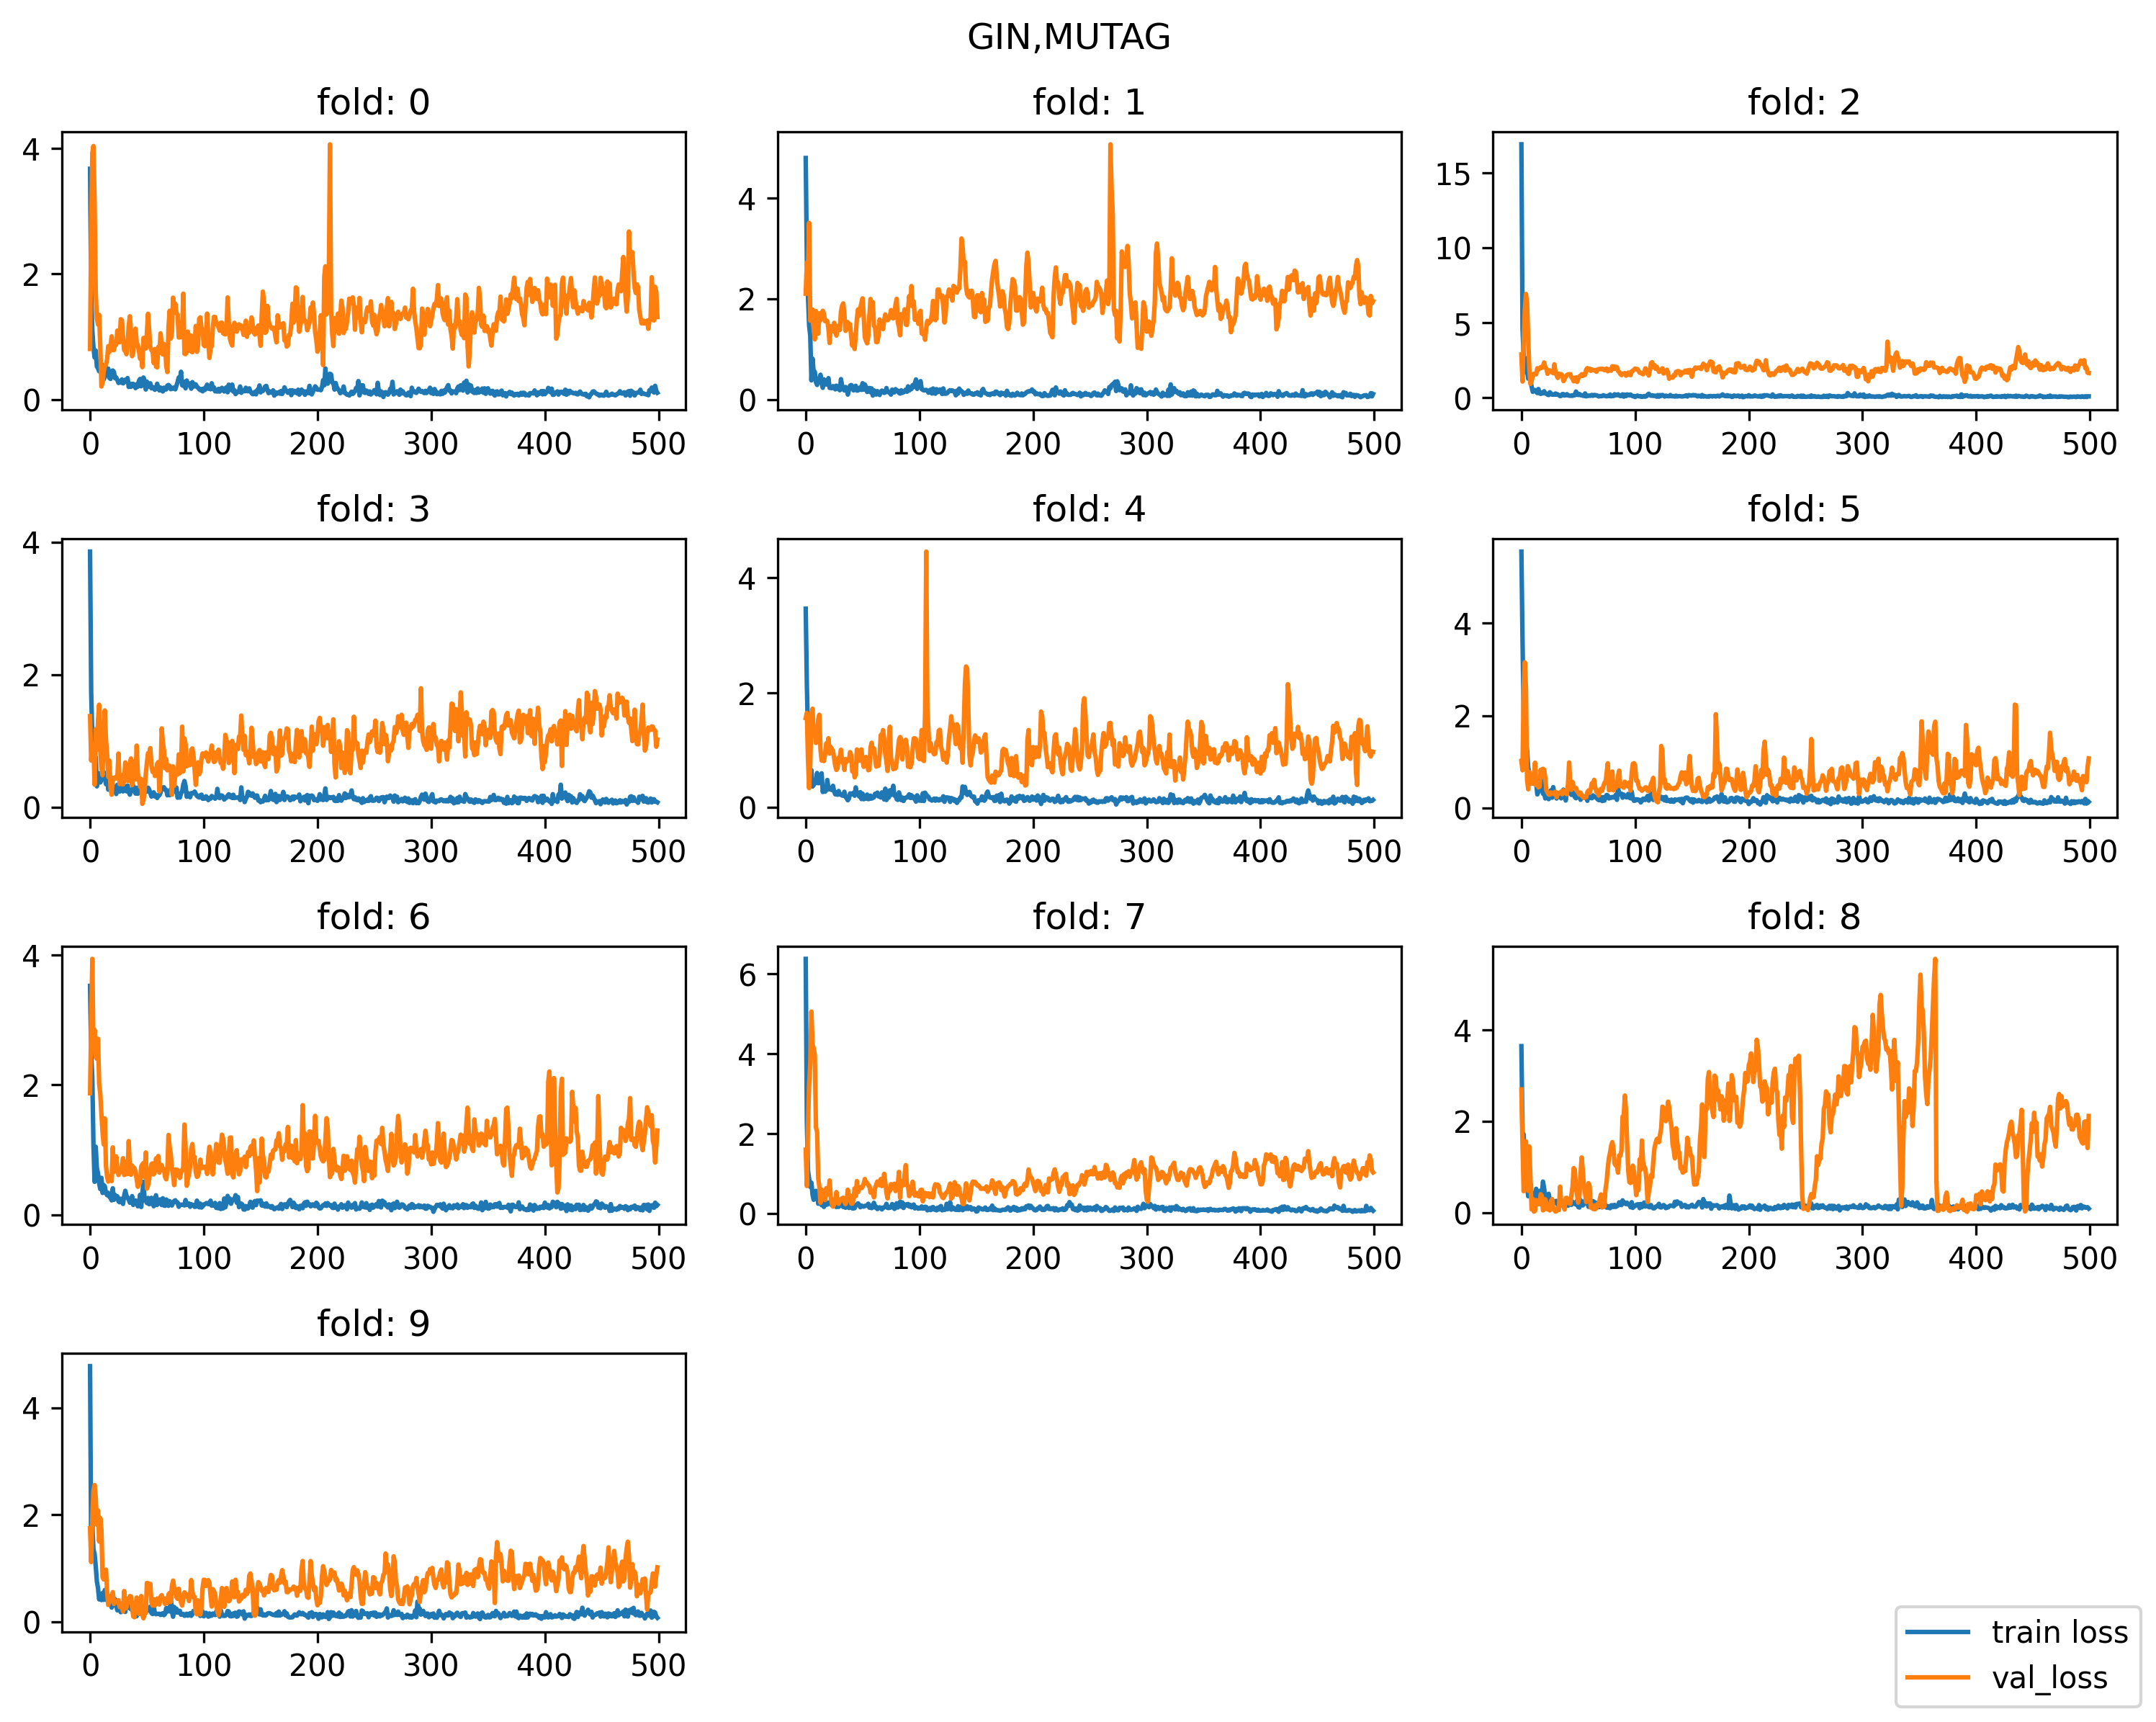

In [27]:
for k, v in stats.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k)
    plot_loss_curve(loss_log, titles)
    
# TODO: Try not normalization.
# TODO: try different distributions of node initialization.

# TODO: using different node initializations:

In [ ]:
stats_1023 = load_logs(date=1023)

for k, v in stats_1023.items():
    print('dataset name: ', k, 'fold len:', len(v))


In [ ]:
for k, v in stats_1023.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k)
    plot_loss_curve(loss_log, titles)
    
# has N fold.
# TODO: plot N fold first, then we may pick one best.

In [ ]:
stats_1023 = load_logs(date=1023)

for k, v in stats_1023.items():
    print('dataset name: ', k, 'fold len:', len(v))
    

loss_log, titles = [], []
for k, v in stats_1023.items():
    loss_log.append(v)
    titles.append(k)
    plot_loss_curve(loss_log, titles)
    break
    
# has N fold.
# TODO: plot N fold first, then we may pick one best.


# TODO: pick the best config from each fold?
# what is the majority one?